The purpose of this notebook is to create a dataframe that allows us to compare the accuracy/Brier Score of multiple prediction models. In this version, we estiamte the probability a team wins via three strategies in which we compare three stats that are meant to represent team strengh. Those are: 

1. Win Percentage
2. Pythagorean Expectation
3. (Relative) Weibull Run distribution

For each game, we compute the relative difference between the strength of each team and assign a probability of victory based on that difference by a logistic regression (see https://github.com/TheErdosInstitute/code-2023/blob/main/lectures/supervised-learning/classification/4.%20Logistic%20Regression%20-%20Complete.ipynb). Our logistic regression is based on the complete knowledge of the prior season. Below are predictions for the 2000-2009 MLB seasons.

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from itertools import chain
import math
from scipy import stats
from sklearn.linear_model import LogisticRegression
import seaborn as sns


The data collected in this cell is used to compute the logistic curves that will be used to compute the probability of victory for the following season. 

In [145]:
#Train data to get logisitic prob curve

years_t = range(1999, 2019)
df_t = []

for year in years_t:

    print(year, ' Test')
    
    df = pd.read_csv(r"C:\Users\wipaw\Desktop\baseball erdos\retrosheet_game_data\gl"+ str(year) + ".txt", header = None)
    cols_drop = [1,2,4,7]
    cols_drop = cols_drop + list(range(11,16))+list(range(17,101))+list(range(105,161))
    df = df.drop(columns = cols_drop)
    df =df.rename(columns = {0:"Date",3: "Away", 6: "Home", 9: "Score A", 10: "Score H", 
                         16: "Park ID", 101: "Away Pitcher ID", 102: "Away Pitcher", 
                         103 : "Home Pitcher ID", 104 : "Home Pitcher", 5: 'GP A', 8: 'GP H'  })

    #drop pitchers and park for now
    df = df.drop(columns = ['Park ID', 'Away Pitcher ID', 'Home Pitcher ID', 'Home Pitcher', 'Away Pitcher'])

    #result is 0 if Away team wins, 1 if home team wins

    df['result'] = 0
    mask = df['Score A'] < df['Score H']
    df.loc[mask, 'result'] = 1



    df['Wins A'] = 0
    df['Wins H'] = 0
    df['W pct A'] = np.nan
    df['W pct H'] = np.nan

    df['runs_s A'] = np.nan
    df['runs_s H'] = np.nan

    df['runs_a A'] = np.nan
    df['runs_a H'] = np.nan
    
    df['avg runs_s A'] = np.nan
    df['avg runs_s H'] = np.nan

    df['avg runs_a A'] = np.nan
    df['avg runs_a H'] = np.nan

    df['pythag A'] = np.nan
    df['pythag H'] = np.nan

    df['gamma_s A'] = np.nan
    df['gamma_s H'] = np.nan
    df['gamma_a A'] = np.nan
    df['gamma_a H'] = np.nan

    team_names = df['Home'].unique()

    for team in team_names:


        mask_a = (df['Away'] == team)
        mask_h = (df['Home'] == team)
        mask = ((df['Away'] == team)| (df['Home'] == team))

        team_wins = pd.concat([df.loc[mask_h,'result'], (1-df.loc[mask_a,'result'])]).sort_index().cumsum()

        team_runs_s = pd.concat([df.loc[mask_h,'Score H'], df.loc[mask_a,'Score A']]).sort_index().cumsum()

        team_runs_a = pd.concat([df.loc[mask_h,'Score A'], df.loc[mask_a,'Score H']]).sort_index().cumsum()

        team_gp = pd.concat([df.loc[mask_h,'GP H'], df.loc[mask_a,'GP A']]).sort_index()


        df.loc[mask_a, 'GP A']  = team_gp.loc[mask_a]
        df.loc[mask_h, 'GP H']  = team_gp.loc[mask_h]

        df.loc[mask_a,'Wins A'] = team_wins.loc[mask_a]
        df.loc[mask_h,'Wins H'] = team_wins.loc[mask_h]

        df.loc[mask_a, 'W pct A'] = df.loc[mask_a,'Wins A']/df.loc[mask_a, 'GP A']
        df.loc[mask_h, 'W pct H'] = df.loc[mask_h,'Wins H']/df.loc[mask_h, 'GP H']

        df.loc[mask_a, 'runs_s A']= team_runs_s.loc[mask_a]
        df.loc[mask_h, 'runs_s H']= team_runs_s.loc[mask_h]

        df.loc[mask_a, 'runs_a A']= team_runs_a.loc[mask_a]
        df.loc[mask_h, 'runs_a H']= team_runs_a.loc[mask_h]

        df.loc[mask_a, 'pythag A'] = df.loc[mask_a, 'runs_s A']**2 /(df.loc[mask_a, 'runs_s A']**2 + df.loc[mask_a, 'runs_a A']**2)
        df.loc[mask_h, 'pythag H'] = df.loc[mask_h, 'runs_s H']**2 /(df.loc[mask_h, 'runs_s H']**2 + df.loc[mask_h, 'runs_a H']**2)
        
        df['avg runs_s A'] = df['runs_s A']/df['GP A']
        df['avg runs_s H'] = df['runs_s H']/df['GP H']

        df['avg runs_a A'] = df['runs_a A']/df['GP A']
        df['avg runs_a H'] = df['runs_a H']/df['GP H']
        
        gamma = 1.82
        beta = 0

        df.loc[mask_a, 'gamma_s A'] = (df.loc[mask_a, 'runs_s A']/df.loc[mask_a,'GP A'] - beta)/(math.gamma(1+ 1/gamma))
        df.loc[mask_h, 'gamma_s H'] = (df.loc[mask_h, 'runs_s H']/df.loc[mask_h,'GP H'] - beta)/(math.gamma(1+ 1/gamma))
        df.loc[mask_a, 'gamma_a A'] = (df.loc[mask_a, 'runs_a A']/df.loc[mask_a,'GP A'] - beta)/(math.gamma(1+ 1/gamma))
        df.loc[mask_h, 'gamma_a H'] = (df.loc[mask_h, 'runs_a H']/df.loc[mask_h,'GP H'] - beta)/(math.gamma(1+ 1/gamma))


        wpct = np.nan

        if( df[mask].iloc[-1]['Home'] == team):
            wpct = df[mask].iloc[-1]['W pct H']
        else:
            wpct = df[mask].iloc[-1]['W pct A']

        df.loc[mask_a, 'W pct A'] = wpct
        df.loc[mask_h, 'W pct H'] = wpct

        pythag = np.nan

        if( df[mask].iloc[-1]['Home'] == team):
            pythag = df[mask].iloc[-1]['pythag H']
        else:
            pythag = df[mask].iloc[-1]['pythag A']

        df.loc[mask_a, 'pythag A'] = pythag
        df.loc[mask_h, 'pythag H'] = pythag

        gamma_s = np.nan

        if( df[mask].iloc[-1]['Home'] == team):
            gamma_s = df[mask].iloc[-1]['gamma_s H']
        else:
            gamma_s = df[mask].iloc[-1]['gamma_s A']

        df.loc[mask_a, 'gamma_s A'] = gamma_s
        df.loc[mask_h, 'gamma_s H'] = gamma_s

        gamma_a = np.nan

        if( df[mask].iloc[-1]['Home'] == team):
            gamma_a = df[mask].iloc[-1]['gamma_a H']
        else:
            gamma_a = df[mask].iloc[-1]['gamma_a A']

        df.loc[mask_a, 'gamma_a A'] = gamma_a
        df.loc[mask_h, 'gamma_a H'] = gamma_a

        
        df['pythag diff'] = df['pythag A'] - df['pythag H']
        
        df['W pct diff'] = df['W pct A'] - df['W pct H']
        
        df['rel weibull diff'] = (df['gamma_s A'] + df['gamma_a H'])/2. - (df['gamma_s H'] + df['gamma_a A'])/2.
        
        
    
    # in this section we calculate the opponent adjusted offensive and defensive efficiency
    
    df['off eff A'] = np.nan
    df['off eff H'] = np.nan

    df['def eff A'] = np.nan
    df['def eff H'] = np.nan

    for team in team_names:
        print(team)

        mask_a = (df['Away'] == team)
        mask_h = (df['Home'] == team)


        off_eff = pd.concat([ (df.loc[mask_h, 'Score H'] / df.loc[mask_h,'avg runs_a A'] )- 1,
                                (df.loc[mask_a, 'Score A']/df.loc[mask_a,'avg runs_a H']) - 1]).sort_index()

        off_eff = off_eff.expanding().mean()

        def_eff = pd.concat( [1-  ( df.loc[mask_h, 'Score A'] / df.loc[mask_h,'avg runs_s A']),
                                 1 - ( df.loc[mask_a, 'Score H'] / df.loc[mask_a,'avg runs_s H'] )  ]).sort_index()

        def_eff = def_eff.expanding().mean()


        df.loc[mask_a, 'off eff A'] = off_eff.loc[mask_a]
        df.loc[mask_h, 'off eff H'] = off_eff.loc[mask_h]

        df.loc[mask_a, 'def eff A'] = def_eff.loc[mask_a]
        df.loc[mask_h, 'def eff H'] = def_eff.loc[mask_h]

    for team in team_names:

        mask = (df['Away'] == team) | (df['Home'] == team)
        mask_a = df['Away'] == team
        mask_h = df['Home'] == team

        val = np.nan

        if(df.loc[mask].iloc[-1]['Away'] == team):
            val = df.loc[mask_a].iloc[-1]['def eff A']
        else:
            val = df.loc[mask_h].iloc[-1]['def eff H']

        df.loc[mask_a, 'def eff A'] = val
        df.loc[mask_h, 'def eff H'] = val

        if(df.loc[mask].iloc[-1]['Away'] == team):
            val = df.loc[mask_a].iloc[-1]['off eff A']
        else:
            val = df.loc[mask_h].iloc[-1]['off eff H']

        df.loc[mask_a, 'off eff A'] = val
        df.loc[mask_h, 'off eff H'] = val



    df['tot eff A'] = df['off eff A'] + df['def eff A']
    df['tot eff H'] = df['off eff H'] + df['def eff H']

    df['eff diff'] = df['tot eff A'] - df['tot eff H']

    df_t.append(df)


1999  Test
SDN
BAL
KCA
OAK
SEA
TEX
ATL
CIN
FLO
LAN
PIT
SLN
ANA
MIN
HOU
MON
SFN
CHA
NYA
TBA
CLE
DET
TOR
ARI
CHN
COL
NYN
PHI
BOS
MIL
2000  Test
NYN
CHN
ATL
CIN
FLO
MON
SLN
ANA
BAL
MIN
OAK
TEX
TOR
ARI
PIT
SEA
HOU
KCA
TBA
COL
MIL
PHI
SDN
SFN
BOS
DET
NYA
LAN
CHA
CLE
2001  Test
TOR
BAL
CLE
NYA
SEA
CHN
CIN
COL
FLO
LAN
SFN
DET
TBA
TEX
ATL
HOU
BOS
CHA
KCA
OAK
ARI
MIL
MON
PHI
MIN
NYN
PIT
SLN
ANA
SDN
2002  Test
ANA
BAL
BOS
KCA
OAK
SEA
ARI
ATL
CIN
NYN
SLN
TBA
HOU
LAN
MON
TOR
DET
NYA
TEX
CHN
MIL
PHI
SFN
CLE
COL
FLO
PIT
SDN
CHA
MIN
2003  Test
ANA
BAL
DET
KCA
TBA
TOR
ARI
ATL
CIN
FLO
NYN
SDN
SLN
OAK
HOU
CHA
MIN
TEX
COL
MIL
PHI
LAN
SFN
CLE
NYA
SEA
CHN
PIT
MON
BOS
2004  Test
TBA
BAL
CIN
HOU
LAN
PIT
SLN
KCA
MIN
OAK
TOR
ARI
ATL
FLO
SEA
SDN
DET
NYA
MIL
MON
BOS
TEX
CHN
COL
NYN
PHI
SFN
CLE
ANA
CHA
2005  Test
NYA
BAL
CHA
DET
SEA
TBA
ARI
CIN
COL
PHI
PIT
ANA
FLO
HOU
SFN
SDN
MIN
TOR
ATL
CHN
SLN
BOS
CLE
KCA
OAK
TEX
MIL
NYN
LAN
WAS
2006  Test
CHA
BAL
KCA
OAK
SEA
TEX
CIN
COL
HOU
LAN
MIL
NYN
PHI
SDN
TOR
SFN
ANA
CLE


Here we collect trailing data which will be used to make predictions. 

In [146]:
years = range(2000, 2020)

df_y = []

for year in years:

    print(year)

    df = pd.read_csv(r"C:\Users\wipaw\Desktop\baseball erdos\retrosheet_game_data\gl"+str(year)+ ".txt", header = None)
    cols_drop = [1,2,4,7]
    cols_drop = cols_drop + list(range(11,16))+list(range(17,101))+list(range(105,161))
    df = df.drop(columns = cols_drop)
    df =df.rename(columns = {0:"Date",3: "Away", 6: "Home", 9: "Score A", 10: "Score H", 
                         16: "Park ID", 101: "Away Pitcher ID", 102: "Away Pitcher", 
                         103 : "Home Pitcher ID", 104 : "Home Pitcher", 5: 'GP A', 8: 'GP H'  })

    #drop pitchers and park for now
    df = df.drop(columns = ['Park ID', 'Away Pitcher ID', 'Home Pitcher ID', 'Home Pitcher', 'Away Pitcher'])

    #result is 0 if Away team wins, 1 if home team wins

    df['result'] = 0
    mask = df['Score A'] < df['Score H']
    df.loc[mask, 'result'] = 1


    df['Wins A'] = 0
    df['Wins H'] = 0
    df['W pct A'] = np.nan
    df['W pct H'] = np.nan

    df['runs_s A'] = np.nan
    df['runs_s H'] = np.nan

    df['runs_a A'] = np.nan
    df['runs_a H'] = np.nan
    
    df['avg runs_s A'] = np.nan
    df['avg runs_s H'] = np.nan

    df['avg runs_a A'] = np.nan
    df['avg runs_a H'] = np.nan

    df['pythag A'] = np.nan
    df['pythag H'] = np.nan

    df['gamma_s A'] = np.nan
    df['gamma_s H'] = np.nan
    df['gamma_a A'] = np.nan
    df['gamma_a H'] = np.nan

    team_names = df['Home'].unique()

    for team in team_names:
        #print(team)
        mask_a = (df['Away'] == team)
        mask_h = (df['Home'] == team)
        mask = ((df['Away'] == team)| (df['Home'] == team))

        team_wins = pd.concat([df.loc[mask_h,'result'], (1-df.loc[mask_a,'result'])]).sort_index().cumsum().shift(1)

        team_runs_s = pd.concat([df.loc[mask_h,'Score H'], df.loc[mask_a,'Score A']]).sort_index().cumsum().shift(1)

        team_runs_a = pd.concat([df.loc[mask_h,'Score A'], df.loc[mask_a,'Score H']]).sort_index().cumsum().shift(1)

        team_gp = pd.concat([df.loc[mask_h,'GP H'], df.loc[mask_a,'GP A']]).sort_index().shift(1)

        df.loc[mask_a, 'GP A']  = team_gp.loc[mask_a]
        df.loc[mask_h, 'GP H']  = team_gp.loc[mask_h]

        df.loc[mask_a,'Wins A'] = team_wins.loc[mask_a]
        df.loc[mask_h,'Wins H'] = team_wins.loc[mask_h]

        df.loc[mask_a, 'W pct A'] = df.loc[mask_a,'Wins A']/df.loc[mask_a, 'GP A']
        df.loc[mask_h, 'W pct H'] = df.loc[mask_h,'Wins H']/df.loc[mask_h, 'GP H']

        df.loc[mask_a, 'runs_s A']= team_runs_s.loc[mask_a]
        df.loc[mask_h, 'runs_s H']= team_runs_s.loc[mask_h]

        df.loc[mask_a, 'runs_a A']= team_runs_a.loc[mask_a]
        df.loc[mask_h, 'runs_a H']= team_runs_a.loc[mask_h]
        
        df['avg runs_s A'] = df['runs_s A']/df['GP A']
        df['avg runs_s H'] = df['runs_s H']/df['GP H']

        df['avg runs_a A'] = df['runs_a A']/df['GP A']
        df['avg runs_a H'] = df['runs_a H']/df['GP H']

        df.loc[mask_a, 'pythag A'] = df.loc[mask_a, 'runs_s A']**2 /(df.loc[mask_a, 'runs_s A']**2 + df.loc[mask_a, 'runs_a A']**2)
        df.loc[mask_h, 'pythag H'] = df.loc[mask_h, 'runs_s H']**2 /(df.loc[mask_h, 'runs_s H']**2 + df.loc[mask_h, 'runs_a H']**2)

        gamma = 1.82
        beta = 0

        df.loc[mask_a, 'gamma_s A'] = (df.loc[mask_a, 'runs_s A']/df.loc[mask_a,'GP A'] - beta)/(math.gamma(1+ 1/gamma))
        df.loc[mask_h, 'gamma_s H'] = (df.loc[mask_h, 'runs_s H']/df.loc[mask_h,'GP H'] - beta)/(math.gamma(1+ 1/gamma))
        df.loc[mask_a, 'gamma_a A'] = (df.loc[mask_a, 'runs_a A']/df.loc[mask_a,'GP A'] - beta)/(math.gamma(1+ 1/gamma))
        df.loc[mask_h, 'gamma_a H'] = (df.loc[mask_h, 'runs_a H']/df.loc[mask_h,'GP H'] - beta)/(math.gamma(1+ 1/gamma))

                
        
    # in this section we calculate the opponent adjusted offensive and defensive efficiency
        
    df['off eff A'] = np.nan
    df['off eff H'] = np.nan

    df['def eff A'] = np.nan
    df['def eff H'] = np.nan

    for team in team_names:
        print(team)

        mask_a = (df['Away'] == team)
        mask_h = (df['Home'] == team)


        off_eff = pd.concat([ (df.loc[mask_h, 'Score H'] / df.loc[mask_h,'avg runs_a A'] )- 1,
                                (df.loc[mask_a, 'Score A']/df.loc[mask_a,'avg runs_a H']) - 1]).sort_index()

        off_eff = off_eff.expanding().mean()

        def_eff = pd.concat( [1-  ( df.loc[mask_h, 'Score A'] / df.loc[mask_h,'avg runs_s A']),
                                 1 - ( df.loc[mask_a, 'Score H'] / df.loc[mask_a,'avg runs_s H'] )  ]).sort_index()

        def_eff = def_eff.expanding().mean()


        df.loc[mask_a, 'off eff A'] = off_eff.loc[mask_a]
        df.loc[mask_h, 'off eff H'] = off_eff.loc[mask_h]

        df.loc[mask_a, 'def eff A'] = def_eff.loc[mask_a]
        df.loc[mask_h, 'def eff H'] = def_eff.loc[mask_h]
    
    df['pythag diff'] = df['pythag A'] - df['pythag H']
    df['W pct diff'] = df['W pct A'] - df['W pct H']
    df['rel weibull diff'] = (df['gamma_s A'] + df['gamma_a H'])/2. - (df['gamma_s H'] + df['gamma_a A'])/2.

    df['tot eff A'] = df['off eff A'] + df['def eff A']
    df['tot eff H'] = df['off eff H'] + df['def eff H']
    
    df['eff diff'] = df['tot eff A'] - df['tot eff H']

    
    df_y.append(df)


2000
NYN
CHN
ATL
CIN
FLO
MON
SLN
ANA
BAL
MIN
OAK
TEX
TOR
ARI
PIT
SEA
HOU
KCA
TBA
COL
MIL
PHI
SDN
SFN
BOS
DET
NYA
LAN
CHA
CLE
2001
TOR
BAL
CLE
NYA
SEA
CHN
CIN
COL
FLO
LAN
SFN
DET
TBA
TEX
ATL
HOU
BOS
CHA
KCA
OAK
ARI
MIL
MON
PHI
MIN
NYN
PIT
SLN
ANA
SDN
2002
ANA
BAL
BOS
KCA
OAK
SEA
ARI
ATL
CIN
NYN
SLN
TBA
HOU
LAN
MON
TOR
DET
NYA
TEX
CHN
MIL
PHI
SFN
CLE
COL
FLO
PIT
SDN
CHA
MIN
2003
ANA
BAL
DET
KCA
TBA
TOR
ARI
ATL
CIN
FLO
NYN
SDN
SLN
OAK
HOU
CHA
MIN
TEX
COL
MIL
PHI
LAN
SFN
CLE
NYA
SEA
CHN
PIT
MON
BOS
2004
TBA
BAL
CIN
HOU
LAN
PIT
SLN
KCA
MIN
OAK
TOR
ARI
ATL
FLO
SEA
SDN
DET
NYA
MIL
MON
BOS
TEX
CHN
COL
NYN
PHI
SFN
CLE
ANA
CHA
2005
NYA
BAL
CHA
DET
SEA
TBA
ARI
CIN
COL
PHI
PIT
ANA
FLO
HOU
SFN
SDN
MIN
TOR
ATL
CHN
SLN
BOS
CLE
KCA
OAK
TEX
MIL
NYN
LAN
WAS
2006
CHA
BAL
KCA
OAK
SEA
TEX
CIN
COL
HOU
LAN
MIL
NYN
PHI
SDN
TOR
SFN
ANA
CLE
CHN
DET
TBA
ATL
PIT
SLN
BOS
MIN
NYA
ARI
FLO
WAS
2007
SLN
CIN
COL
HOU
MIL
PHI
WAS
ANA
CHA
DET
KCA
MIN
NYA
SEA
SFN
ATL
FLO
SDN
TBA
TEX
ARI
CHN
LAN
NYN
PIT
BAL
OAK
TOR
BOS
CLE


Finally, we compare the accuracy and Brier Score of our three models.

In [61]:
len(df_y[0])

2429

In [170]:
#whole season ~2430 games, around 2380 games to ensure no error

num_games = 240


wpct = np.zeros(len(years))
pyth = np.zeros(len(years))
wb_s = np.zeros(len(years))
wb_a = np.zeros(len(years))
wb_b = np.zeros(len(years))
eff = np.zeros(len(years))
eff_h = np.zeros(len(years))

pyth_bscore = np.zeros(len(years))
wpct_bscore = np.zeros(len(years))
wb_bscore = np.zeros(len(years))
eff_bscore = np.zeros(len(years))
eff_h_bscore = np.zeros(len(years))

elo_df = pd.read_csv(r"C:\Users\wipaw\Desktop\baseball erdos\mlb_elo.csv")

years = range(2000, 2020)

elo = np.zeros(len(years))

for i in range(len(years)):
        
    year_data = elo_df.loc[elo_df.season == years[i]].sort_values(by= 'date')

    year_data = year_data[year_data.playoff.isnull()]


    year_data.insert(len(year_data.T),"actual", (year_data["score1"].values>year_data["score2"])*1)
    
    elo[i] = np.linalg.norm(year_data[-num_games:]['elo_prob1']-year_data[-num_games:]['actual'])**2/len(year_data[-num_games:])
    

for i in range(len(df_y)):
        
    ##pythagorean
    log_pyth = LogisticRegression(penalty='none')

    log_pyth.fit(df_t[i]['pythag diff'].to_numpy().reshape(-1,1), 1-df_t[i]['result'].to_numpy())

    #FIXME
    pyth_prob = log_pyth.predict_proba(df_y[i][-num_games:]['pythag diff'].to_numpy().reshape(-1,1))[:,1] 
    
    #FIXME
    res = 1-df_y[i][-num_games:]['result'].to_numpy()
    
    pyth_bscore[i] = np.linalg.norm(pyth_prob-res)**2/len(res)
    
    ## Win percentage
    log_wpct = LogisticRegression(penalty='none')

    log_wpct.fit(df_t[i]['W pct diff'].to_numpy().reshape(-1,1), 1-df_t[i]['result'].to_numpy())

    wpct_prob = log_wpct.predict_proba(df_y[i][-num_games:]['W pct diff'].to_numpy().reshape(-1,1))[:,1]

    wpct_bscore[i] = np.linalg.norm(wpct_prob-res)**2/len(res)


    ## Weibull gamma diff
    log_wb = LogisticRegression(penalty='none')

    log_wb.fit(df_t[i]['rel weibull diff'].to_numpy().reshape(-1,1), 1-df_t[i]['result'].to_numpy())

    wb_prob = log_wb.predict_proba(df_y[i][-num_games:]['rel weibull diff'].to_numpy().reshape(-1,1))[:,1]

    wb_bscore[i] = np.linalg.norm(wb_prob-res)**2/len(res)
        
        
    ## Efficiency diff
    log_eff = LogisticRegression(penalty='none')

    log_eff.fit(df_t[i]['eff diff'].to_numpy().reshape(-1,1), 1-df_t[i]['result'].to_numpy())

    # FIXME
    eff_prob = log_eff.predict_proba(df_y[i][-num_games:]['eff diff'].to_numpy().reshape(-1,1))[:,1] 
        
    eff_bscore[i] = np.linalg.norm(eff_prob-res)**2/len(res)
    
    eff_h_prob = eff_prob - 0.04 # 4 percent homefield adjustment
    
    eff_h_bscore[i] = np.linalg.norm(eff_h_prob-res)**2/len(res)

    

    mask_p = ((df_y[i][-num_games:]['pythag A'] > df_y[i][-num_games:]['pythag H'])*(1- df_y[i][-num_games:]['result']) )| (
                (df_y[i][-num_games:]['pythag A'] < df_y[i][-num_games:]['pythag H'])*(df_y[i][-num_games:]['result']))

    
    mask_w = ((df_y[i][-num_games:]['W pct A'] > df_y[i][-num_games:]['W pct H'])*(1- df_y[i][-num_games:]['result']) )| (
            (df_y[i][-num_games:]['W pct A'] < df_y[i][-num_games:]['W pct H'])*(df_y[i][-num_games:]['result']))

    
    mask_wb_s = ((df_y[i][-num_games:]['gamma_s A'] > df_y[i][-num_games:]['gamma_s H'])*(1- df_y[i][-num_games:]['result']) )| (
                (df_y[i][-num_games:]['gamma_s A'] < df_y[i][-num_games:]['gamma_s H'])*(df_y[i][-num_games:]['result']))
    
    mask_wb_a = ((df_y[i][-num_games:]['gamma_a A'] < df_y[i][-num_games:]['gamma_a H'])*(1- df_y[i][-num_games:]['result']) )| (
                (df_y[i][-num_games:]['gamma_a A'] > df_y[i][-num_games:]['gamma_a H'])*(df_y[i][-num_games:]['result']))
    
    mask_wb_b = ((df_y[i][-num_games:]['rel weibull diff'] > 0)*(1- df_y[i][-num_games:]['result']) )| (
        (df_y[i][-num_games:]['rel weibull diff'] < 0)*(df_y[i][-num_games:]['result']))
    
    
    mask_eff = ((df_y[i][-num_games:]['tot eff A'] > df_y[i][-num_games:]['tot eff H'])*(1- df_y[i][-num_games:]['result']) )| (
                (df_y[i][-num_games:]['tot eff A'] < df_y[i][-num_games:]['tot eff H'])*(df_y[i][-num_games:]['result']))

    
    wpct[i] = (mask_w.sum()/num_games)
    pyth[i] =(mask_p.sum()/num_games)
    wb_s[i] =(mask_wb_s.sum()/num_games)
    wb_a[i] =(mask_wb_a.sum()/num_games)

    wb_b[i] =(mask_wb_b.sum()/num_games)

    eff[i] = (mask_eff.sum()/ num_games)
    
#     print(years[i])
#     print('Win Percentage: ', round(mask_w.sum()/num_games,3), ' on ', num_games, ' games')
    
#     print('Pythag Percentage: ',round( mask_p.sum()/num_games,3), ' on ', num_games, ' games')

#     print('WB_s Percentage: ', round(mask_wb_s.sum()/num_games,3), ' on ', num_games, ' games')

#     print('WB_a Percentage: ', round(mask_wb_a.sum()/num_games,3), ' on ', num_games, ' games')

#     print('WB_b Percentage: ', round(mask_wb_b.sum()/num_games,3), ' on ', num_games, ' games')
    
#     print('Eff Percentage: ', round(mask_eff.sum()/num_games,3), ' on ', num_games, ' games')

#     print()


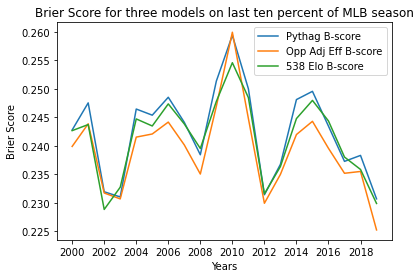

In [171]:
plt.plot(years,pyth_bscore, label = 'Pythag B-score')
#plt.plot(years,wpct_bscore, label = 'W pct B-score')
#plt.plot(years,wb_bscore, label = 'WB B-score')
plt.plot(years,eff_bscore, label = 'Opp Adj Eff B-score')
#plt.plot(years,eff_h_bscore, label = 'Eff_h B-score')
plt.plot(years, elo, label = '538 Elo B-score')

plt.xticks(range(2000,2020,2))

plt.xlabel('Years')
plt.ylabel('Brier Score')

plt.legend()
plt.title('Brier Score for three models on last ten percent of MLB season')

plt.show()

In [172]:
print('For predictions made on the last ', num_games, ' games of the 2000-2019 MLB seasons')
print()

print("Pythagorean B-Score mean: ", round(np.mean(pyth_bscore),4), " with std: ",
      round( np.std(pyth_bscore)/np.sqrt(len(pyth_bscore)),4 )  ) 

print("Opp Adj Eff B-Score mean: ", round(np.mean(eff_bscore),4), " with std: ",
      round( np.std(eff_bscore)/np.sqrt(len(eff_bscore)),4 )  ) 

print("538 Elo Model B-Score mean: ", round(np.mean(elo),4), " with std: ",
      round( np.std(elo)/np.sqrt(len(elo)),4 )  ) 

print()
print('Corr coef between Adj Opp and 538 Elo:', round(np.corrcoef(eff_bscore, elo)[0,1], 3))
print('Corr coef between Adj Opp and Pythag:', round(np.corrcoef(eff_bscore, pyth_bscore)[0,1], 3))
print('Corr coef between Pythag and 538 Elo:', round(np.corrcoef(elo, pyth_bscore)[0,1], 3))


# data = { 'Pythag' : pyth_bscore,
#         'Opp Adj': eff_bscore,
#         '538 Elo': elo
# }
# df_corr = pd.DataFrame(data)

# corr = df_corr.corr()

# sns.heatmap(corr, cmap = 'coolwarm')

# plt.show()



For predictions made on the last  240  games of the 2000-2019 MLB seasons

Pythagorean B-Score mean:  0.2426  with std:  0.0017
Opp Adj Eff B-Score mean:  0.2394  with std:  0.0016
538 Elo Model B-Score mean:  0.2413  with std:  0.0015

Corr coef between Adj Opp and 538 Elo: 0.943
Corr coef between Adj Opp and Pythag: 0.972
Corr coef between Pythag and 538 Elo: 0.978


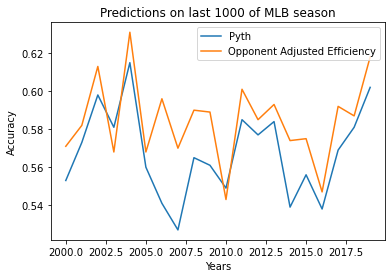

In [13]:
#plt.plot(years,wpct, label = 'W pct')
plt.plot(years,pyth, label = 'Pyth')
#plt.plot(years,wb_s, label = 'WB Scored')
#plt.plot(years,wb_a, label = 'WB Allowed')
#plt.plot(years,wb_b, label = 'WB Both')
plt.plot(years,eff, label = 'Opponent Adjusted Efficiency')


plt.xlabel('Years')
plt.ylabel('Accuracy')

plt.legend()
plt.title('Predictions on last '+ str(num_games)+ ' of MLB season')

plt.show()

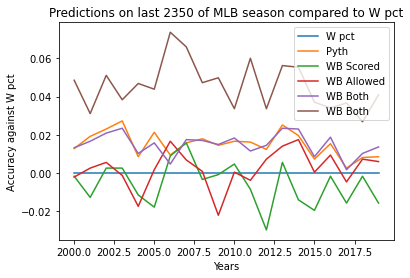

In [79]:
plt.plot(years,np.zeros(len(years)), label = 'W pct')

plt.plot(years,pyth - wpct, label = 'Pyth')
plt.plot(years,wb_s- wpct, label = 'WB Scored')
plt.plot(years,wb_a- wpct, label = 'WB Allowed')
plt.plot(years,wb_b- wpct, label = 'WB Both')
plt.plot(years,eff- wpct, label = 'WB Both')


plt.xlabel('Years')
plt.ylabel('Accuracy against W pct')

plt.legend()
plt.title('Predictions on last '+ str(num_games)+ ' of MLB season compared to W pct')

plt.show()